## Refit and produce score distribution
---

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import lightgbm as lgb
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

from rdsutils.psi import calculate_psi

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

### Prep Data
---

In [2]:
# load modeling_df
dev_path = "../../data/combined_all_features/combined_1616138792.feather"
df = pd.read_feather(dev_path)
df = mu.preprocess(df)

In [3]:
start = pd.to_datetime("2019-01-01")
end = pd.to_datetime("2020-11-30")  # 1 m
modeling_df = df[df.sample_date.between(start, end)]
valid_df_dec = df[(df.is_static==True) &
              (df.sample_date==pd.to_datetime("2020-12-01"))]

### Refitted Model
---

In [4]:
# prev model
prev_model_s3_key = "jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
old_model = mu.read_pickle_from_s3("sofi-data-science", prev_model_s3_key)

In [5]:
# new_model = lgb.LGBMClassifier(init_model="artifacts/model_20201130.txt")
new_model_booster = lgb.Booster(model_file="artifacts/model_20201130.txt")

In [6]:
valid_df_dec["pred_20200101"] = old_model.predict_proba(valid_df_dec[old_model.feature_name_])[:,1]
valid_df_dec["score_20200101"] = mu.scale_scores(valid_df_dec["pred_20200101"])

valid_df_dec["pred_20201130"] = new_model_booster.predict(valid_df_dec[old_model.feature_name_])
valid_df_dec["score_20201130"] = mu.scale_scores(valid_df_dec["pred_20201130"])

### Performance
---

In [7]:
pred_cols = ["score_20200101", "score_20201130"]

----- data size -----
(568715, 98)
----- performance report -----


,auc,ap,ks
score_20200101,73.97,15.24,31.49
score_20201130,91.83,37.99,68.37


----- performance plots -----


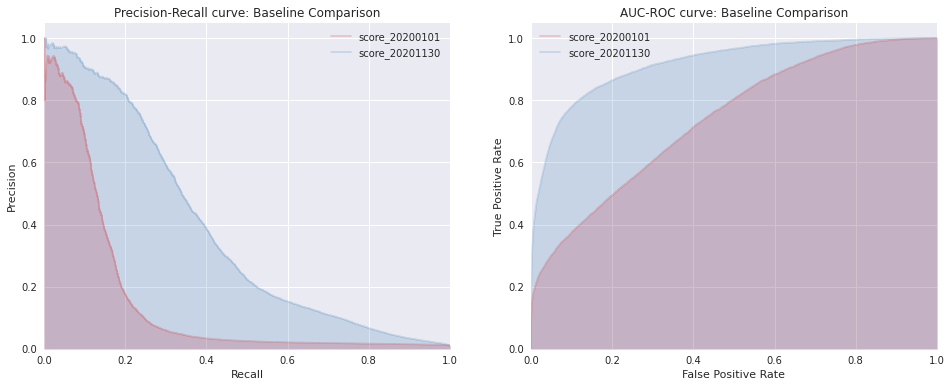

In [8]:
df_ = valid_df_dec
print("----- data size -----")
print(df_.shape)
print("----- performance report -----")
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
display(report)

print("----- performance plots -----")
mntr.save_valid_performance_plots(
    {"model_stability_exp": df_}, "target", pred_cols, "./artifacts", dropna=False
)

In [9]:
def scale_scores_(predictions,
                 alpha = 631.9455383610933, 
                 beta = 30.812519272450654):
    """
    Convert probability to score.
    """
    try:
        assert ((predictions >= 0) & (predictions <= 1)).all(), 'probability must be in range [0,1]'
    except AssertionError:
        raise
    # Minimum and maximum values for validation
    MINIMUM = 300
    MAXIMUM = 850

    score = np.minimum(np.maximum(np.log(predictions / (1 - predictions)) * beta + alpha, MINIMUM), MAXIMUM)
   
    return score

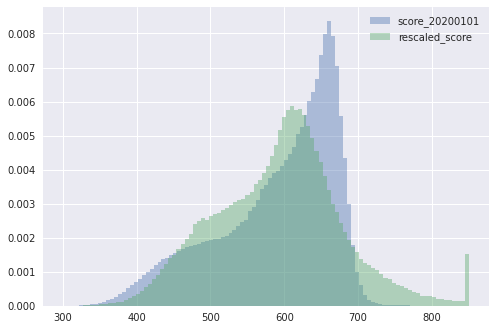

In [10]:
# rescaled score
x = [743.17590331,  59.30207539]  # obtained below
bins = 100
alpha, beta = x

valid_df_dec["score_rescaled"] = scale_scores_(valid_df_dec.pred_20201130, 
                                               alpha=alpha, beta=beta)
density = True
valid_df_dec.score_20200101.hist(bins=bins, alpha=0.4, density=density, label="score_20200101") # immediately after training
# valid_df_dec.score_20201130.hist(bins=100, alpha=0.4, density=density, label="score_20201130")
valid_df_dec.score_rescaled.hist(bins=bins, alpha=0.4, density=density, label="rescaled_score")
plt.legend()

In [11]:
s3_path = "s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-03/validation_df_dec.parquet"
valid_df_dec.to_parquet(s3_path)

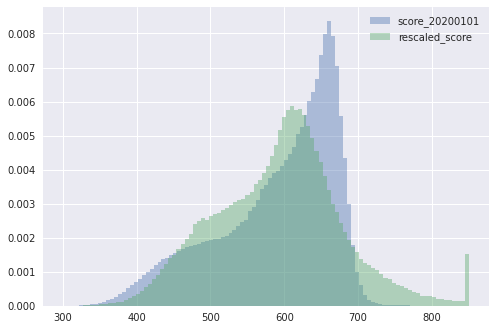

In [12]:
density = True
valid_df_dec.score_20200101.hist(bins=bins, alpha=0.4, density=density, label="score_20200101") # immediately after training
valid_df_dec.score_rescaled.hist(bins=bins, alpha=0.4, density=density, label="rescaled_score")
plt.legend()

### Performance by risk groups
---

In [13]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

valid_df_dec["rg_20200101"] = get_risk_groups(valid_df_dec["score_20200101"])
valid_df_dec.rg_20200101.value_counts().sort_index()

RG1     66245
RG2     38407
RG3     66522
RG4     83468
RG5    314073
Name: rg_20200101, dtype: int64

=============== RG1 ===============
target imbalance


False    0.999426
True     0.000574
Name: target, dtype: float64

'imbalance ratio: '

1743.2894736842104

----- performance report -----


,auc,ap,ks
score_20200101,66.47,0.12,29.04
score_20201130,85.66,6.78,58.79


----- performance plots -----


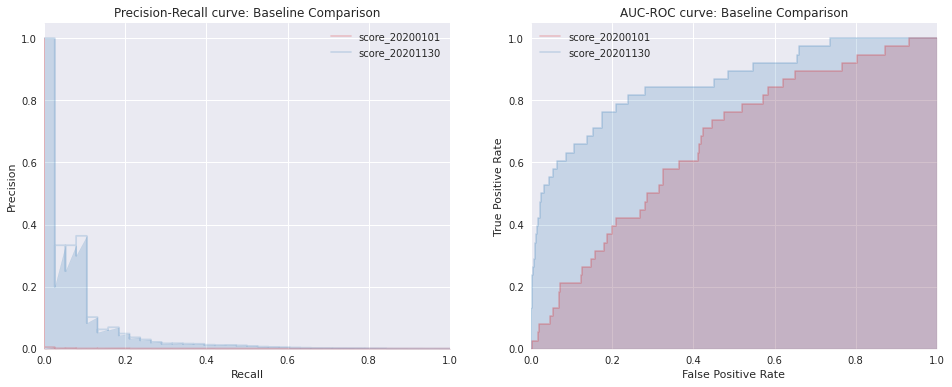

=============== RG2 ===============
target imbalance


False    0.998229
True     0.001771
Name: target, dtype: float64

'imbalance ratio: '

564.8088235294118

----- performance report -----


,auc,ap,ks
score_20200101,53.84,0.22,11.00
score_20201130,88.96,13.02,66.33


----- performance plots -----


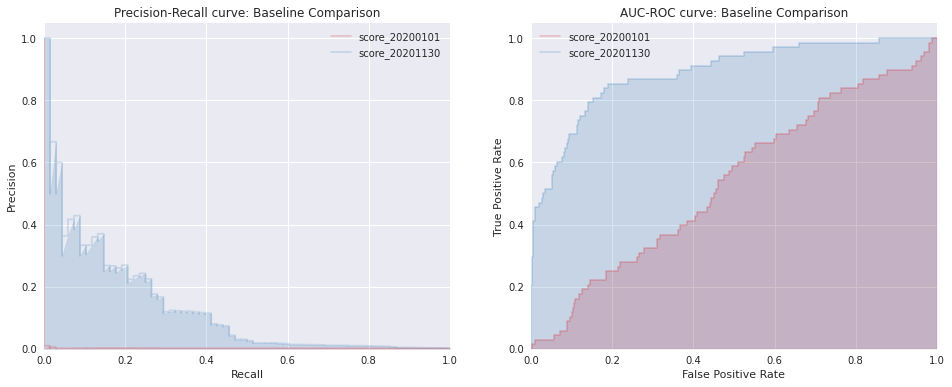

=============== RG3 ===============
target imbalance


False    0.995836
True     0.004164
Name: target, dtype: float64

'imbalance ratio: '

240.15162454873646

----- performance report -----


,auc,ap,ks
score_20200101,56.74,0.54,11.22
score_20201130,90.83,20.78,69.30


----- performance plots -----


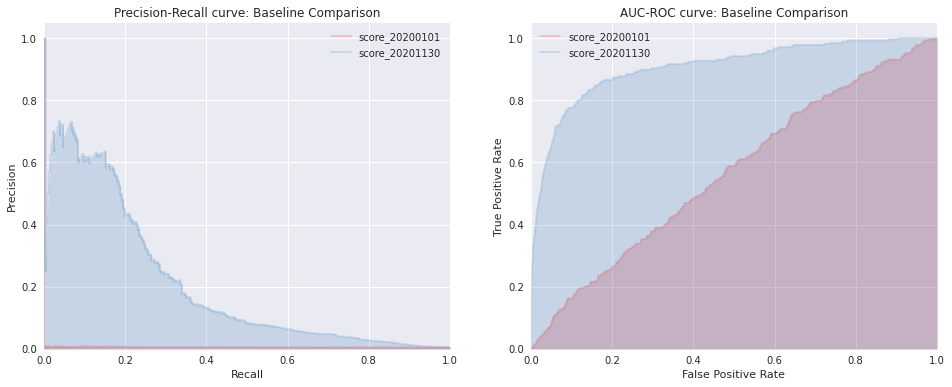

=============== RG4 ===============
target imbalance


False    0.993746
True     0.006254
Name: target, dtype: float64

'imbalance ratio: '

159.90038314176243

----- performance report -----


,auc,ap,ks
score_20200101,54.42,0.77,7.31
score_20201130,90.75,15.95,67.58


----- performance plots -----


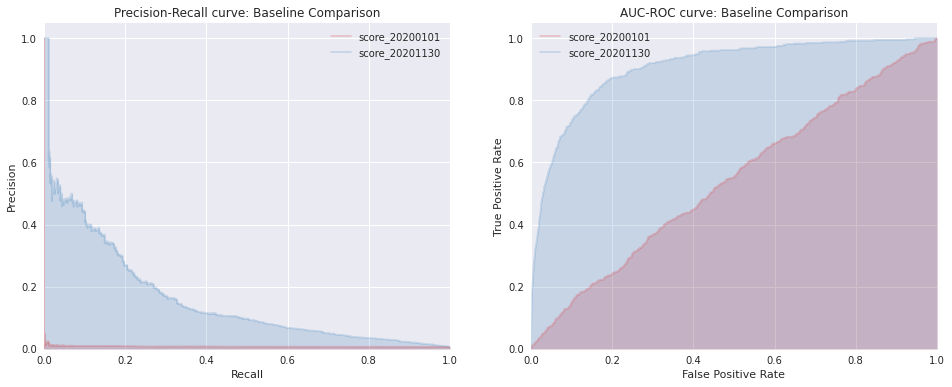

=============== RG5 ===============
target imbalance


False    0.984128
True     0.015872
Name: target, dtype: float64

'imbalance ratio: '

63.0036108324975

----- performance report -----


,auc,ap,ks
score_20200101,66.69,17.75,26.99
score_20201130,89.89,41.83,66.02


----- performance plots -----


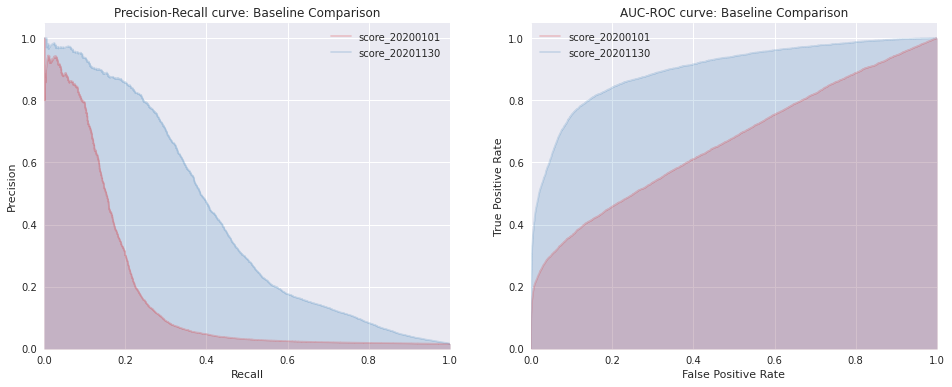

In [14]:
risk_groups = sorted(valid_df_dec.rg_20200101.unique())
for rg_ in risk_groups:
    df_ = valid_df_dec[valid_df_dec.rg_20200101 == rg_]
    print(f"=============== {rg_} ===============")
    print("target imbalance")
    imb_df = df_.target.value_counts(normalize=True)
    display(imb_df)
    display("imbalance ratio: ", 1/imb_df.loc[True])
    
    print("----- performance report -----")
    report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
    display(report)

    print("----- performance plots -----")
    mntr.save_valid_performance_plots(
        {"model_stability_exp": df_}, "target", pred_cols, "./artifacts", dropna=False
    )
    plt.show()

### Score Rescaling
---

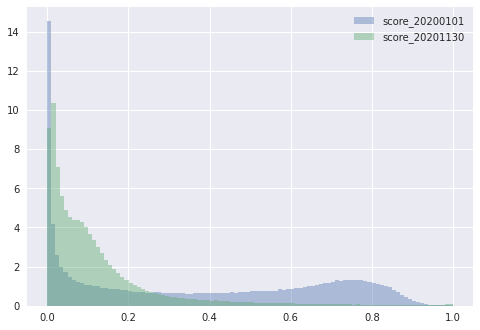

In [15]:
density = True
valid_df_dec.pred_20200101.hist(bins=100, alpha=0.4, density=density, label="score_20200101") # immediately after training
valid_df_dec.pred_20201130.hist(bins=100, alpha=0.4, density=density, label="score_20201130")
plt.legend()

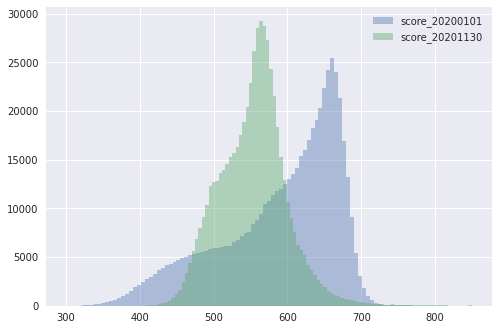

In [16]:
density = False
valid_df_dec.score_20200101.hist(bins=100, alpha=0.4, density=density, label="score_20200101") # immediately after training
valid_df_dec.score_20201130.hist(bins=100, alpha=0.4, density=density, label="score_20201130")
plt.legend()

In [17]:
import numpy as np
import scipy.stats


def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

In [18]:
valid_df_dec["score_rescaled"] = scale_scores_(valid_df_dec.pred_20201130, 
                                        alpha=650, beta=40)

JSD:  0.034837614871799816
PSI:  1.176121909013882


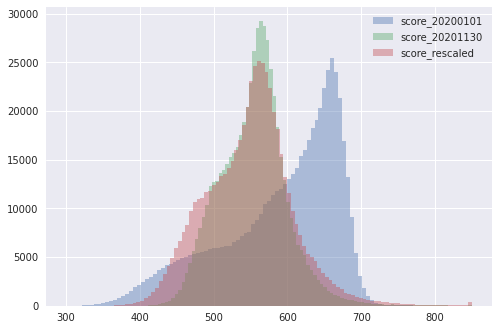

In [19]:
density = False
valid_df_dec.score_20200101.hist(bins=100, alpha=0.4, density=density, label="score_20200101") # immediately after training
valid_df_dec.score_20201130.hist(bins=100, alpha=0.4, density=density, label="score_20201130")
valid_df_dec.score_rescaled.hist(bins=100, alpha=0.4, density=density, label="score_rescaled")
plt.legend()
print("JSD: ", jensen_shannon_distance(valid_df_dec.score_20200101,
                        valid_df_dec.score_rescaled))
print("PSI: ", calculate_psi(valid_df_dec.score_20200101, 
               valid_df_dec.score_rescaled, buckets=100))

In [20]:
from scipy.optimize import minimize

In [21]:
a = 631.9455383610933
b = 30.812519272450654
    
def fn(arg):
    """ distance between the original score distribution and the newly rescaled score distribution """
    alpha, beta = arg
    valid_df_dec["score_rescaled"] =  scale_scores_(
        valid_df_dec.pred_20201130, alpha, beta)
    return calculate_psi(valid_df_dec.score_20200101, 
               valid_df_dec.score_rescaled, buckets=100)

In [22]:
%%time
minimize(fn, x0=(a, b), method="Powell", tol=1e-6)

CPU times: user 34.9 s, sys: 0 ns, total: 34.9 s
Wall time: 34.9 s


   direc: array([[ 5.22462989e+01,  1.49471616e+01],
       [-1.75223974e-15, -2.38522824e-07]])
     fun: 0.3941464915916215
 message: 'Optimization terminated successfully.'
    nfev: 280
     nit: 4
  status: 0
 success: True
       x: array([743.17590331,  59.30207539])

In [23]:
%%time
minimize(fn, x0=(a, b), method="COBYLA", tol=1e-6)

CPU times: user 21.3 s, sys: 0 ns, total: 21.3 s
Wall time: 21.3 s


     fun: 0.395636838381729
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 169
  status: 1
 success: True
       x: array([739.14735889,  57.87249742])

In [24]:
# results
x = [743.17590331,  59.30207539]

alpha, beta = x

JSD:  0.037678517635847814
PSI:  0.3941464915916215


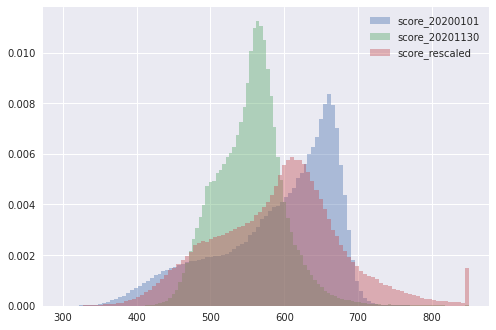

In [25]:
valid_df_dec["score_rescaled"] = scale_scores_(valid_df_dec.pred_20201130, 
                                               alpha=alpha, beta=beta)
density = True
valid_df_dec.score_20200101.hist(bins=100, alpha=0.4, density=density, label="score_20200101") # immediately after training
valid_df_dec.score_20201130.hist(bins=100, alpha=0.4, density=density, label="score_20201130")
valid_df_dec.score_rescaled.hist(bins=100, alpha=0.4, density=density, label="score_rescaled")
plt.legend()
print("JSD: ", jensen_shannon_distance(valid_df_dec.score_20200101,
                        valid_df_dec.score_rescaled))
print("PSI: ", calculate_psi(valid_df_dec.score_20200101, 
               valid_df_dec.score_rescaled, buckets=100))

### RG distributions - Compute Lorenz Curve - bump?

---
Goal:
* minimize score shift at current point in time
    * `find a risk group cut off that, segment on the new score, so the percentage of users mimic the old rgs, while maining minimal score shift`
    * shifts among rg 3-5 has more impact relative to 1-2. Minimize shift 3-5 range more if it is an option.
    
Instead of producting a score distribution that matches the old distribution, let's see if I can find a way to segment the scores so that the score shifts are minimized.

This is not a easy task... due to it's constrained optimization nature.
    
#### Deliverable: rescaled score and rescaled risk group

Notes:
* quaintiles
* swap-in swap-out analysis
    * swap qua
* <5-10% migration between risk groups -> aggregated view
* adjacent migration
* **produce risk group cut offs distributions to match with the current ones**
    * put the "matching bad rate/odds" in the too hard bin right now
    * any bin number minimum? - use the current risk group distribution
    
    

### Produce result for 3/3/2021 and look into the Gap
---

In [26]:
df = pd.read_feather("s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/202103/dev_static_20210303.feather")
df = mu.preprocess(df)
df.shape, df.sample_date.unique()

((774082, 107),
 array(['2021-03-03T00:00:00.000000000'], dtype='datetime64[ns]'))

In [27]:
df["age_money_account"] = (
        df["sample_date"] - df["date_account_opened"]
    ).dt.days

In [28]:
# prev model
prev_model_s3_key = "jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
old_model = mu.read_pickle_from_s3("sofi-data-science", prev_model_s3_key)

In [29]:
# new_model = lgb.LGBMClassifier(init_model="artifacts/model_20201130.txt")
new_model_booster = lgb.Booster(model_file="artifacts/model_20201130.txt")

In [30]:
df["pred_20200101"] = old_model.predict_proba(df[old_model.feature_name_])[:,1]
df["score_20200101"] = mu.scale_scores(df["pred_20200101"])

df["pred_20201130"] = new_model_booster.predict(df[old_model.feature_name_])
df["score_20201130"] = mu.scale_scores(df["pred_20201130"])

In [31]:
def scale_scores_(predictions,
                 alpha = 631.9455383610933, 
                 beta = 30.812519272450654):
    """
    Convert probability to score.
    """
    try:
        assert ((predictions >= 0) & (predictions <= 1)).all(), 'probability must be in range [0,1]'
    except AssertionError:
        raise
    # Minimum and maximum values for validation
    MINIMUM = 300
    MAXIMUM = 850

    score = np.minimum(np.maximum(np.log(predictions / (1 - predictions)) * beta + alpha, MINIMUM), MAXIMUM)
   
    return score

In [ ]:
# results
x = [743.17590331,  59.30207539]

alpha, beta = x

df["score_rescaled"] = scale_scores_(df.pred_20201130, 
                                     alpha=alpha, beta=beta)
density = True
df.score_20200101.hist(bins=100, alpha=0.4, density=density, label="score_20200101") # immediately after training
df.score_rescaled.hist(bins=100, alpha=0.4, density=density, label="score_rescaled")
plt.legend()

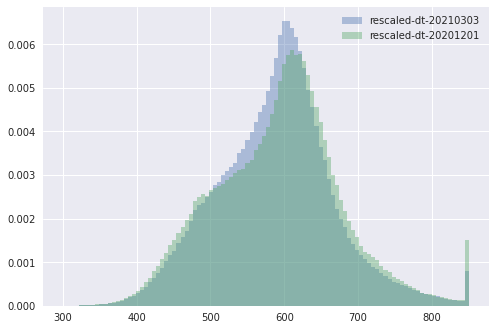

In [33]:
density = True
bins=100
df.score_rescaled.hist(bins=bins, alpha=0.4, density=density, label="rescaled-dt-20210303") # immediately after training
valid_df_dec.score_rescaled.hist(bins=bins, alpha=0.4, density=density, label="rescaled-dt-20201201")
plt.legend()

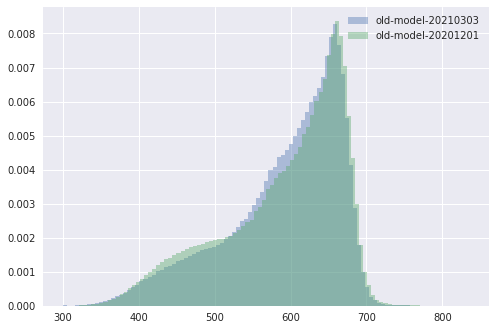

In [34]:
density = True
df.score_20200101.hist(bins=bins, alpha=0.4, density=density, label="old-model-20210303") # immediately after training
valid_df_dec.score_20200101.hist(bins=bins, alpha=0.4, density=density, label="old-model-20201201")
plt.legend()

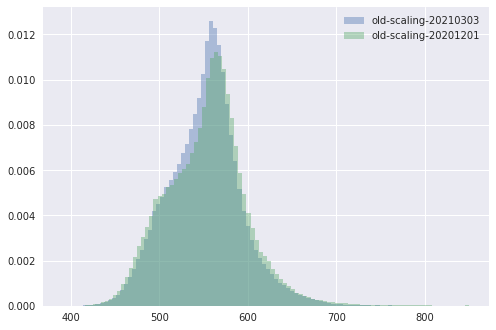

In [35]:
density = True
df.score_20201130.hist(bins=bins, alpha=0.4, density=density, label="old-scaling-20210303") # immediately after training
valid_df_dec.score_20201130.hist(bins=bins, alpha=0.4, density=density, label="old-scaling-20201201")
plt.legend()

In [36]:
df.sample_date.unique()

array(['2021-03-03T00:00:00.000000000'], dtype='datetime64[ns]')

In [37]:
# df.to_parquet("s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-03/validation_df_20210303.parquet")

In [38]:
# cols = ['business_account_number', 'user_id', 'borrower_id', 'sample_date', 
#         'pred_20200101', 'pred_20201130',
#         'score_20200101', 'score_20201130', 'score_rescaled']
# df[cols].to_parquet("s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-03/validation_df_20210303_only_scores.parquet")
# df[cols].to_csv("s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-03/validation_df_20210303_only_scores.csv")

### Lorenz Curve
---

In [39]:
# compute the lorenz curve on df.pred_20200101 and df.pred_20201130


### We can basically plot it...and measure with correlation
---

In [46]:
df.columns

Index(['user_id', 'business_account_number', 'date_account_opened',
       'date_account_closed', 'account_type', 'account_closed_reason',
       'joint_user_id', 'account_age_days_asof_pull', 'sample_date',
       'borrower_id',
       ...
       'indeterminate', 'transaction_code_encoded', 'all7120_default_encoded',
       'bcc7120_default_encoded', 'age_money_account', 'pred_20200101',
       'score_20200101', 'pred_20201130', 'score_20201130', 'score_rescaled'],
      dtype='object', length=113)

In [55]:
df_ = df_.sample(frac=0.1)

<AxesSubplot:xlabel='pred_20200101', ylabel='pred_20201130'>

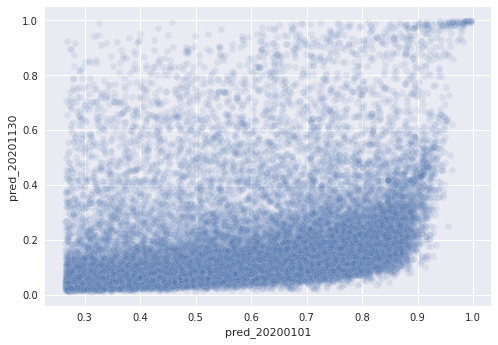

In [56]:
import seaborn as sns

sns.scatterplot(x=df_.pred_20200101, 
                y=df_.pred_20201130, 
                alpha=0.1)

<AxesSubplot:xlabel='score_20200101', ylabel='score_20201130'>

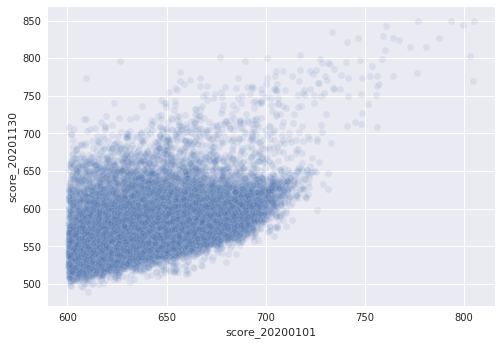

In [57]:
sns.scatterplot(x=df_.score_20200101, 
                y=df_.score_20201130,
                alpha=0.1)

In [58]:
df[["score_20200101", "score_20201130"]].corr()

,score_20200101,score_20201130
score_20200101,1.000000,0.634158
score_20201130,0.634158,1.000000
